# Scraping Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


In [ ]:
!ls "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project"

cloud-pacs-air-preproc-and-gradcam.ipynb	output_gradcam
data						__pycache__
grad_cam.py					test.csv
ham						train.csv
images1.zip					util.py
image-segmentation-masked-kaggledatasets.ipynb	val.csv
model						xray_dataset.csv
output_clahe					X_Ray_Image_Enhancement_using_CLAHE.ipynb


In [ ]:
# images1 = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images1.zip"
# images2 = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images2.zip"
# images3 = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images3.zip"
# PATH = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/data"


# !unzip -uq "{images1}" -d "{PATH}"
# !unzip -uq "{images2}" -d "{PATH}"
# !unzip -uq "{images3}" -d "{PATH}"

unzip:  cannot find or open /content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images2.zip, /content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images2.zip.zip or /content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images2.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images3.zip, /content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images3.zip.zip or /content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/images3.zip.ZIP.


In [ ]:
import os

# Define the directory path
directory_path = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/data"

# List all files in the directory
files = os.listdir(directory_path)

if files:
    # Sort files alphabetically
    files.sort()
    last_file = files[-1]
    print("Last file (sorted alphabetically):", last_file)
else:
    print("No files found in the directory.")


Last file (sorted alphabetically): 00006585_006.png


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import sys
sys.path.append('/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project')

import util

# Preprocessing

## One-hot-encoding

In [ ]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [ ]:
# Load your original dataset
original_csv_file = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/xray_dataset.csv"
df = pd.read_csv(original_csv_file)

In [ ]:
df.rename(columns = {'Finding Labels':'Findings'}, inplace = True)
df['Findings'] = df['Findings'].str.split('|')
df = df.explode('Findings')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30134 entries, 0 to 24998
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  30134 non-null  object 
 1   Findings                     30134 non-null  object 
 2   Follow-up #                  30134 non-null  int64  
 3   Patient ID                   30134 non-null  int64  
 4   Patient Age                  30134 non-null  int64  
 5   Patient Gender               30134 non-null  object 
 6   View Position                30134 non-null  object 
 7   OriginalImage[Width          30134 non-null  int64  
 8   Height]                      30134 non-null  int64  
 9   OriginalImagePixelSpacing[x  30134 non-null  float64
 10  y]                           30134 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 2.8+ MB


In [ ]:
# One-hot encode the 'Findings' column
df = pd.get_dummies(df, columns=['Findings'])

# Extract columns that start with 'Findings_'
findings_columns = [col for col in df.columns if col.startswith('Findings_')]

# Rename the findings columns to remove the 'Findings_' prefix
renamed_columns = {col: col.replace('Findings_', '') for col in findings_columns}
df.rename(columns=renamed_columns, inplace=True)

# Convert boolean values to 1 and 0
df[labels] = df[labels].astype(int)

# Group by 'ID' and aggregate by taking the maximum to combine the rows
df = df.groupby('Image Index').max().reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24999 entries, 0 to 24998
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  24999 non-null  object 
 1   Follow-up #                  24999 non-null  int64  
 2   Patient ID                   24999 non-null  int64  
 3   Patient Age                  24999 non-null  int64  
 4   Patient Gender               24999 non-null  object 
 5   View Position                24999 non-null  object 
 6   OriginalImage[Width          24999 non-null  int64  
 7   Height]                      24999 non-null  int64  
 8   OriginalImagePixelSpacing[x  24999 non-null  float64
 9   y]                           24999 non-null  float64
 10  Atelectasis                  24999 non-null  int64  
 11  Cardiomegaly                 24999 non-null  int64  
 12  Consolidation                24999 non-null  int64  
 13  Edema           

In [ ]:
df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,57,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,False,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,False,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,False,0,0,0,0
3,00000002_000.png,0,2,80,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,True,0,0,0,0
4,00000003_000.png,7,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,1,0,0,False,0,0,0,0


## Train Val Test Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the dataset into train and (temporarily) combined validation/test sets
train, test = train_test_split(df, test_size=0.1, random_state = 1)

# Further split the combined validation/test set into separate validation and test sets
train, val = train_test_split(train, test_size=0.25, random_state = 1)

# Save the split datasets to separate CSV files
train.to_csv("/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/train.csv", index=False)
val.to_csv("/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/val.csv", index=False)
test.to_csv("/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/test.csv", index=False)

print("Train, validation, and test CSV files created successfully.")

Train, validation, and test CSV files created successfully.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16874 entries, 20344 to 9679
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  16874 non-null  object 
 1   Follow-up #                  16874 non-null  int64  
 2   Patient ID                   16874 non-null  int64  
 3   Patient Age                  16874 non-null  int64  
 4   Patient Gender               16874 non-null  object 
 5   View Position                16874 non-null  object 
 6   OriginalImage[Width          16874 non-null  int64  
 7   Height]                      16874 non-null  int64  
 8   OriginalImagePixelSpacing[x  16874 non-null  float64
 9   y]                           16874 non-null  float64
 10  Atelectasis                  16874 non-null  int64  
 11  Cardiomegaly                 16874 non-null  int64  
 12  Consolidation                16874 non-null  int64  
 13  Edema             

In [ ]:
val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 16462 to 14252
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5625 non-null   object 
 1   Follow-up #                  5625 non-null   int64  
 2   Patient ID                   5625 non-null   int64  
 3   Patient Age                  5625 non-null   int64  
 4   Patient Gender               5625 non-null   object 
 5   View Position                5625 non-null   object 
 6   OriginalImage[Width          5625 non-null   int64  
 7   Height]                      5625 non-null   int64  
 8   OriginalImagePixelSpacing[x  5625 non-null   float64
 9   y]                           5625 non-null   float64
 10  Atelectasis                  5625 non-null   int64  
 11  Cardiomegaly                 5625 non-null   int64  
 12  Consolidation                5625 non-null   int64  
 13  Edema             

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 15754 to 11579
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  2500 non-null   object 
 1   Follow-up #                  2500 non-null   int64  
 2   Patient ID                   2500 non-null   int64  
 3   Patient Age                  2500 non-null   int64  
 4   Patient Gender               2500 non-null   object 
 5   View Position                2500 non-null   object 
 6   OriginalImage[Width          2500 non-null   int64  
 7   Height]                      2500 non-null   int64  
 8   OriginalImagePixelSpacing[x  2500 non-null   float64
 9   y]                           2500 non-null   float64
 10  Atelectasis                  2500 non-null   int64  
 11  Cardiomegaly                 2500 non-null   int64  
 12  Consolidation                2500 non-null   int64  
 13  Edema             

In [ ]:
def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0

    return leakage

print("leakage between train and test: {}".format(check_for_leakage(train, test, 'Image Index')))
print("leakage between valid and test: {}".format(check_for_leakage(val, test, 'Image Index')))

leakage between train and test: False
leakage between valid and test: False


## Training and Testing

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator


In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image Index",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/data"
train_generator = get_train_generator(train, IMAGE_DIR, "Image Index", labels)
valid_generator, test_generator= get_test_and_valid_generator(val, test, train, IMAGE_DIR, "Image Index", labels)

getting train generator...
Found 16874 validated image filenames.
getting train and valid generators...
Found 16874 validated image filenames.
Found 5625 validated image filenames.
Found 2500 validated image filenames.


In [1]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

NameError: name 'train_generator' is not defined

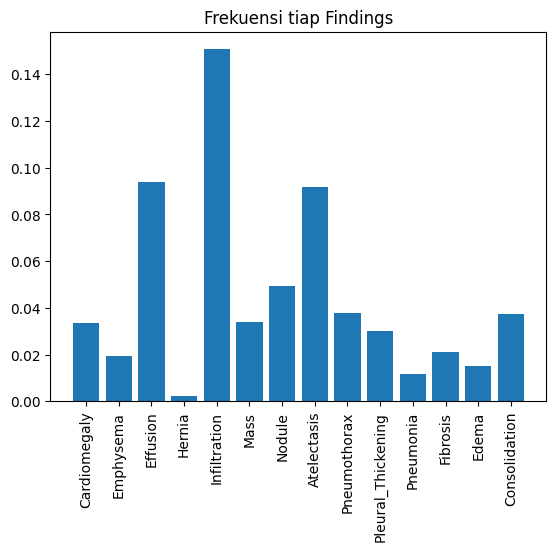

In [ ]:
plt.xticks(rotation=90)
plt.bar(x = labels, height = np.mean(train_generator.labels, axis = 0))
plt.title("Frekuensi tiap Findings")
plt.show()

In [ ]:
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.0334242 , 0.01955671, 0.0937537 , 0.00237051, 0.15064596,
       0.03395757, 0.04960294, 0.09173877, 0.03786891, 0.0299277 ,
       0.01173403, 0.0213346 , 0.01534906, 0.03727628])

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg

        return loss


    return weighted_loss

In [ ]:
import tensorflow

# create the base pre-trained model
base_model = DenseNet121(weights='/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/model/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [ ]:
model.load_weights("/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/model/pretrained_model.h5")

In [ ]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

313/313 [==============================] - 2250s 7s/step


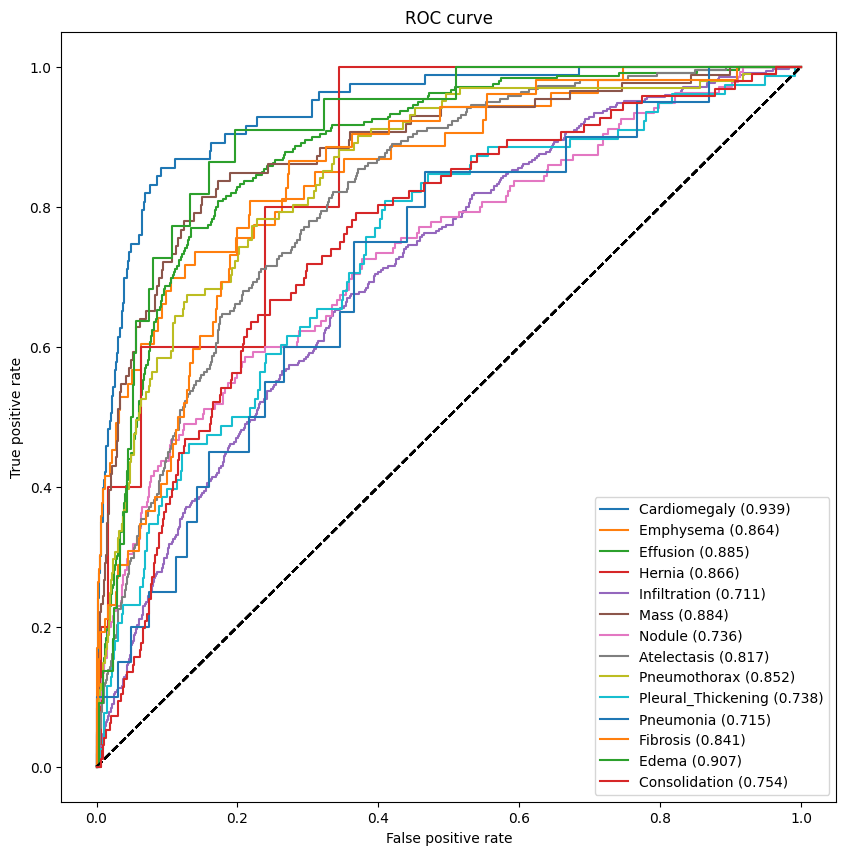

In [ ]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

# Grad-cam Visualization

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# Load the CSV file
test_csv_path = "/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/test.csv"
test = pd.read_csv(test_csv_path)

# Preprocess the images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

test_images = [load_and_preprocess_image(f"/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/data/{img}") for img in test['Image Index']]

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2


# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout laye
predictions = Dense(len(labels), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)
class_weights = dict(enumerate(class_weights))

model.fit(train_data, train_labels, epochs=50, class_weight=class_weights)

In [ ]:
import cv2

class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model(
            [self.model.inputs],
            [self.model.get_layer(self.layer_name).output, self.model.output]
        )

    def compute_heatmap(self, img_array, class_idx):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(img_array)
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        return heatmap

    def apply_heatmap(self, img, heatmap, alpha=0.4):
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        img = np.uint8(img)
        superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
        return superimposed_img

1/1 [==============================] - 0s 30ms/step


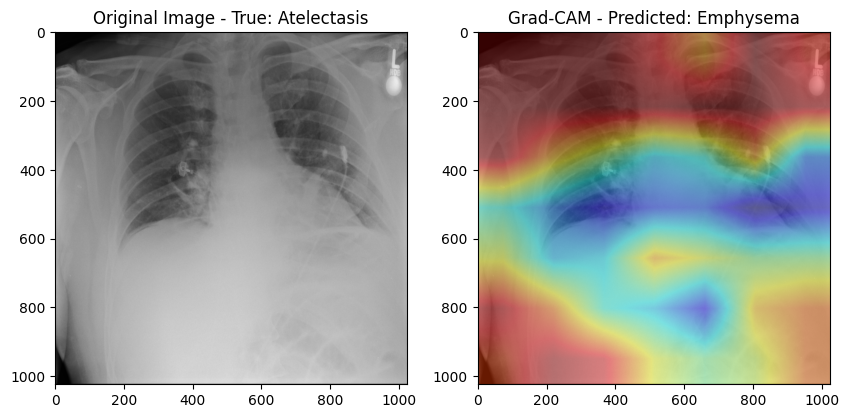

In [ ]:
import matplotlib.pyplot as plt

# Choose an image and its true label
img_path = test['Image Index'].iloc[55]
true_label_indices = test[labels].iloc[55].values.nonzero()[0]  # Assuming 'Label' column exists for true labels
true_labels = [labels[idx] for idx in true_label_indices]
img_array = load_and_preprocess_image(f"/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/data/{img_path}")

# Compute Grad-CAM heatmap
grad_cam = GradCAM(model, 'conv5_block3_out')
preds = model.predict(img_array)

if preds.shape[1] != len(labels):
    raise ValueError(f"Model output shape {preds.shape[1]} does not match the number of labels {len(labels)}.")

class_idx = np.argmax(preds[0])
heatmap = grad_cam.compute_heatmap(img_array, class_idx)

# Map class_idx to the correct label
predicted_label = labels[class_idx % len(labels)]

# Load the original image
img = image.load_img(f"/content/drive/MyDrive/Kalbe x Bangkit 2024 /Data Acquisition/Project/data/{img_path}")
img = image.img_to_array(img)

# Apply heatmap to the original image
superimposed_img = grad_cam.apply_heatmap(img, heatmap)

# Display the image and the Grad-CAM heatmap
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(img.astype('uint8'))
plt.title(f"Original Image - True: {', '.join(true_labels)}")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img.astype('uint8'))
plt.title(f"Grad-CAM - Predicted: {predicted_label}")

plt.show()

In [ ]:
test.iloc[55]

Image Index                    00006282_001.png
Follow-up #                                   1
Patient ID                                 6282
Patient Age                                  57
Patient Gender                                M
View Position                                AP
OriginalImage[Width                        2500
Height]                                    2048
OriginalImagePixelSpacing[x               0.171
y]                                        0.171
Atelectasis                                   1
Cardiomegaly                                  0
Consolidation                                 0
Edema                                         0
Effusion                                      0
Emphysema                                     0
Fibrosis                                      0
Hernia                                        0
Infiltration                                  0
Mass                                          0
No Finding                              